In [27]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

In [2]:

# load the dataset
df = pd.read_excel('Tabs Dataset.xlsx', sheet_name='Sheet2')

df['tab_name'] = df['url_and_tab_name'].apply(lambda x: x.split(' | ')[1])
df['on_topic'].fillna(0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

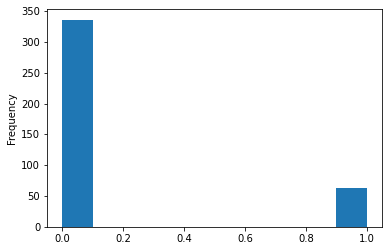

In [28]:
df['on_topic'].plot.hist()

This is a pretty imbalanced problem! I am not focusing much :-)

In [29]:

# prepare the model 

tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

X = tfidf.fit_transform(df['tab_name'])

y = df['on_topic'].astype(int)

# split the data into train and test sets, balanced samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)




# train the model

model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)

# make predictions

y_pred = model.predict(X_test)

# evaluate model with a confusion matrix, and log some example predictions

# calculate precision and recall

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)


print(confusion_matrix(y_test, y_pred))

incorrect = y_test[y_test != y_pred]

incorrect_preds = df.iloc[incorrect.index]


incorrect_preds['prediction'] = incorrect_preds['on_topic'].apply(lambda x: 'Predicted as Off-Topic' if x == 1 else 'Predicted as On-Topic')

print('Precision: ', precision)

print('Recall: ', recall)




[[65  2]
 [10  3]]
Precision:  0.6
Recall:  0.23076923076923078


/Users/noahkasmanoff/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [23]:
incorrect_preds

,url_and_tab_name,on_topic,tab_name,prediction
251,https://jobs.lever.co/boweryfarming/2e79679f-5...,0.0,Bowery Farming - VP of Data & AI,Predicted as On-Topic
237,https://climatepolicyradar.org/jobs | Jobs | C...,1.0,Jobs,Predicted as Off-Topic
232,https://www.actionnetwork.com/nba/nba-elite-10...,0.0,NBA: Ranking the 100 Best Players in the League,Predicted as On-Topic
335,https://twitter.com/BlancheMinerva/status/1691...,0.0,"Stella Rose Biderman @ DEF CON on X: ""@delipra...",Predicted as On-Topic
19,https://news.ycombinator.com/item?id=37739028 ...,1.0,Ask HN: Who is hiring? (October 2023),Predicted as Off-Topic
124,https://www.nbcnews.com/science/science-news/e...,0.0,Eight catastrophic floods in 11 days: What’s b...,Predicted as On-Topic
193,https://www.calameo.com/read/0055032800b7aed88...,0.0,"Edition #001 AI for Flood Resilience, The Worl...",Predicted as On-Topic
103,https://docs.pytest.org/en/7.1.x/how-to/skippi...,0.0,How to use skip and xfail to deal with tests t...,Predicted as On-Topic
141,https://twitter.com/Thom_Wolf/status/170158773...,0.0,"Thomas Wolf on X: ""Sharing a important initiat...",Predicted as On-Topic
184,https://drive.google.com/drive/u/0/folders/19A...,1.0,Job Search Strategizing - Google Drive,Predicted as Off-Topic


As the current results show, this model achieves decent precision, but poor recall. This is likely due to the dataset being so imbalanced, and what it means in practice is that:

high precision = when it does predict something as on topic, it is usually right

low recall = not a lot of the true positives are actually classified as such. As a result, this classifier is a bit harsh, and is tending to predict most things as off topic.

There's certainly more to do in if we wanted to improve this performance and better track, but seeing as this data is so low, manually annotated, and a starting point until I collect more, let's move to the in production aspect to see this end to end.

In [31]:


pickle.dump(model, open('api/focus_model.pkl', 'wb'))

pickle.dump(tfidf, open('api/tfidf.pkl', 'wb'))


# load model and vectorizer

model = pickle.load(open('api/focus_model.pkl', 'rb'))

tfidf = pickle.load(open('api/tfidf.pkl', 'rb'))

# make predictions

model.predict(tfidf.transform(['How to make a website']))





array([0])